### Objetivos
> 1. Identificar se é possível haver segmentação dos países com base nas características fornecidas

> 2. Identificar grupos dos países com base nas features

### Breve Definição
Clusterização é uma técnica de aprendizado não supervisionado usada para agrupar dados semelhantes entre si, de forma que os elementos de um mesmo grupo (cluster) sejam mais parecidos entre si do que com elementos de outros grupos.


Exemplos: segmentação de clientes, produtos.

In [1]:
# !pip install -q -U watermark

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Clusterização"
%watermark --iversions

Author: Clusterização

sklearn_extra: 0.3.0
matplotlib   : 3.9.2
pandas       : 2.2.3
sklearn      : 1.6.0
scipy        : 1.13.1
yellowbrick  : 1.5
seaborn      : 0.13.2
numpy        : 1.26.4



## Dicionário de Dados
| Coluna       | Descrição                                                                                             |
|--------------|-------------------------------------------------------------------------------------------------------|
| `country`    | Nome do país.                                                                                         |
| `child_mort` | Taxa de mortalidade infantil (número de mortes de crianças menores de 5 anos por 1.000 nascimentos). |
| `exports`    | Exportações de bens e serviços como porcentagem do PIB.                                               |
| `health`     | Despesas com saúde como porcentagem do PIB.                                                           |
| `imports`    | Importações de bens e serviços como porcentagem do PIB.                                               |
| `income`     | Renda per capita (PIB per capita).                                                                    |
| `inflation`  | Taxa de inflação anual (variação percentual nos preços ao consumidor).                                |
| `life_expec` | Expectativa de vida ao nascer (em anos).                                                              |
| `total_fer`  | Taxa de fertilidade total (número médio de filhos por mulher).                                        |
| `gdpp`       | Produto Interno Bruto per capita, em dólares americanos.                                              |

In [4]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/leoinfnet/tp1-clusterizacao/refs/heads/main/paises.csv')
except:
    df = pd.read_csv('dataset/paises.csv')

In [5]:
display(df.head())
df.shape

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


(167, 10)

In [6]:
df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [9]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Analisando Correlações

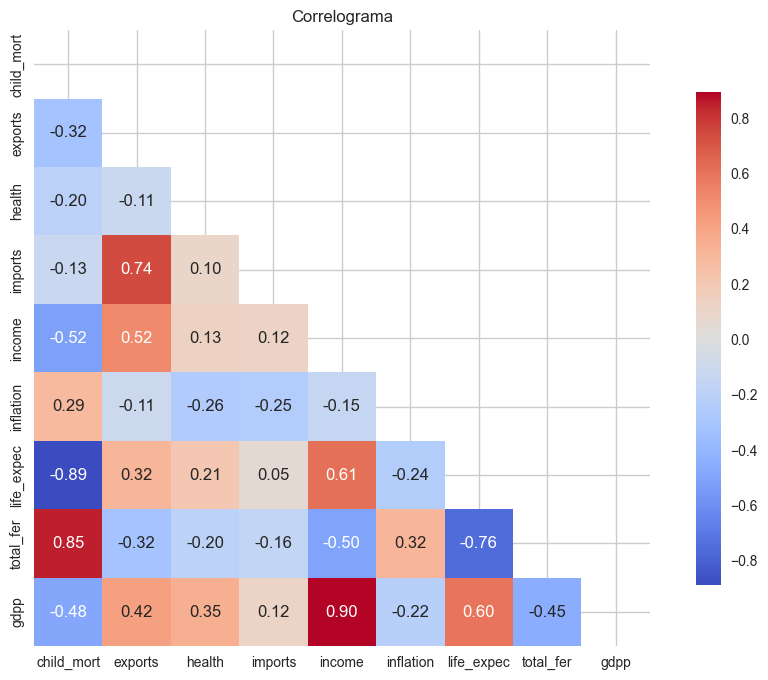

In [10]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.drop(columns=['country']).corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlograma")
plt.show()

#### Primeiras observações
 - Quanto maior a renda, melhor a expectativa de vida, maior o pib também (proporcional e forte).
 - Correlação diretamente proporcional e forte entre exportação e importação.
 - Quanto maior a taxa de fertilidade (quantidade de filhos por mulher), maior a mortalidade infantil; parece apresentar um descontrole.
 - Quanto maior a renda, menos filhos (pode ter alguma relação com excesso de trabalho, escolaridade, é preciso avaliar mais detalhes).

In [11]:
df_clustering = df.drop(['country','exports','imports'], axis=1)
display(df_clustering.head(3))

,child_mort,health,income,inflation,life_expec,total_fer,gdpp
0,90.2,7.58,1610,9.44,56.2,5.82,553
1,16.6,6.55,9930,4.49,76.3,1.65,4090
2,27.3,4.17,12900,16.10,76.5,2.89,4460


### Normalização dos dados

In [12]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_clustering)
normalized_df = pd.DataFrame(normalized_data, columns=df_clustering.columns)

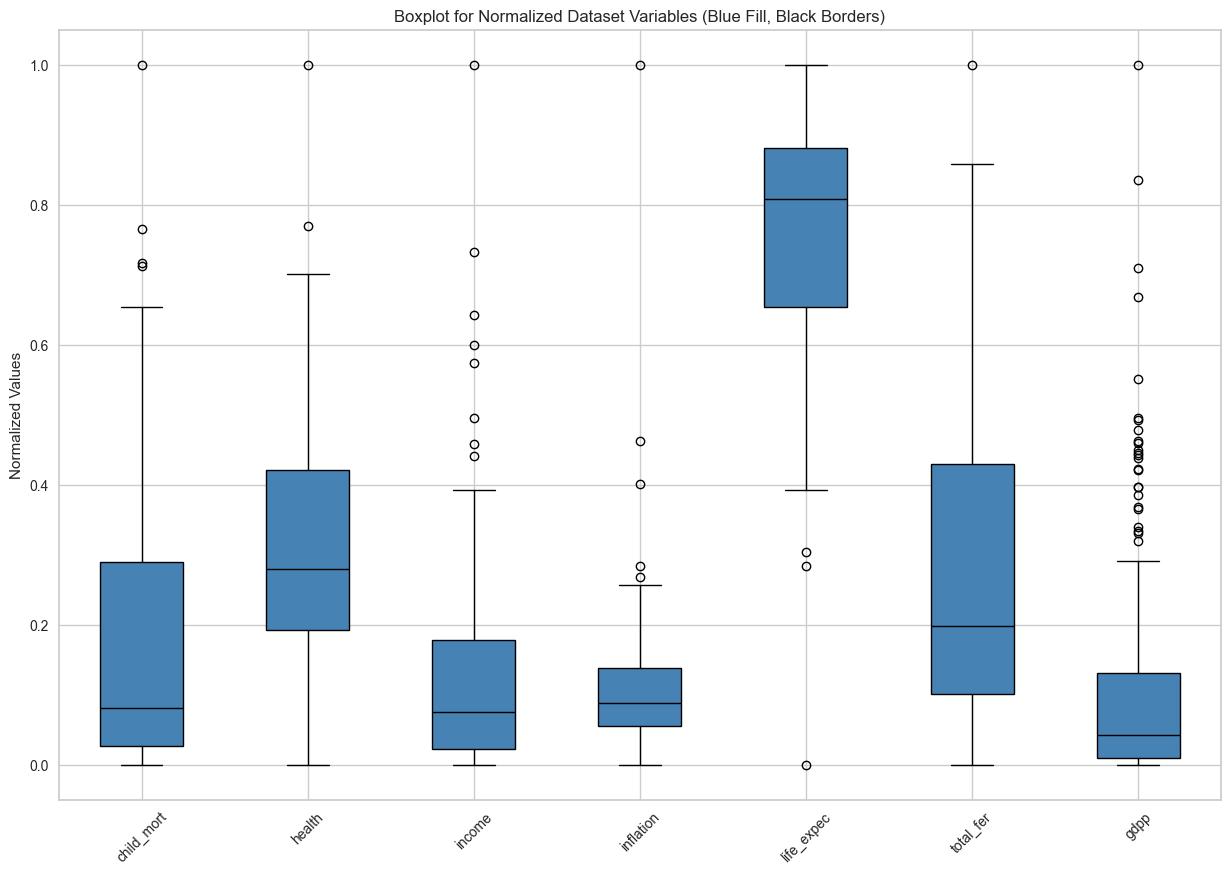

In [13]:
plt.figure(figsize=(15, 10))
box = normalized_df.boxplot(
    patch_artist=True,
    boxprops=dict(facecolor='#4682B4', color='black'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    flierprops=dict(markeredgecolor='black'),
    medianprops=dict(color='black')
)

plt.title("Boxplot for Normalized Dataset Variables (Blue Fill, Black Borders)")
plt.xticks(rotation=45)
plt.ylabel("Normalized Values")
plt.show()

### Tratamento de Outliers
normalized_df2 foi criado para analisar de forma isolada os dados com outliers e os dados sem

In [14]:
def limits(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    range_ = q3 - q1
    return q1 - 1.5 * range_, q3 + 1.5 * range_

def remove_outliers(df, column_name):
    original_row_count = df.shape[0]
    lower_limit, upper_limit = limits(df[column_name])
    df = df.loc[(df[column_name] >= lower_limit) & (df[column_name] <= upper_limit), :]
    rows_removed = original_row_count - df.shape[0]
    return df, rows_removed

def box_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limits(column))
    sns.boxplot(x=column, ax=ax2)

def histogram(column):
    plt.figure(figsize=(15, 5))
    sns.histplot(column, kde=True)

def bar_chart(column):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limits(column))

#### Dataframe normalized_df2 estão os dados com menos outliers

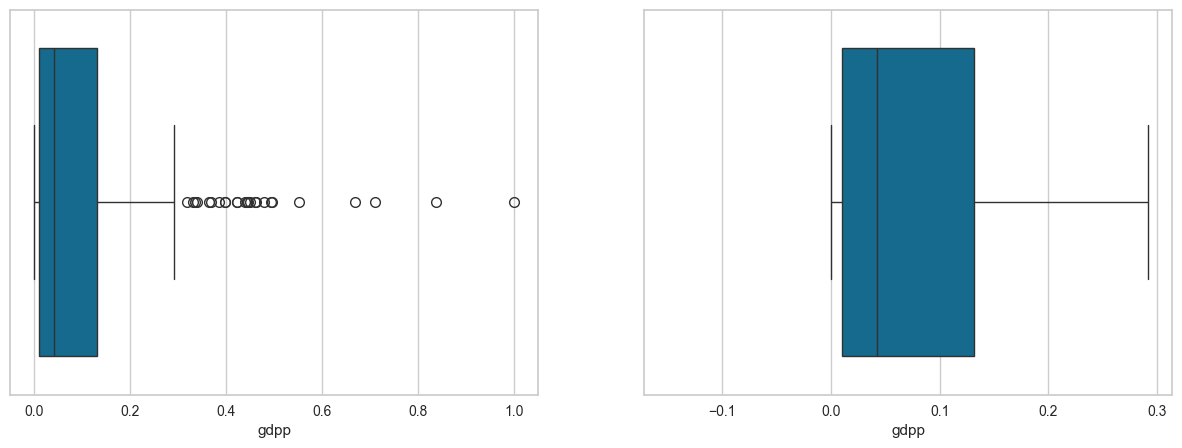

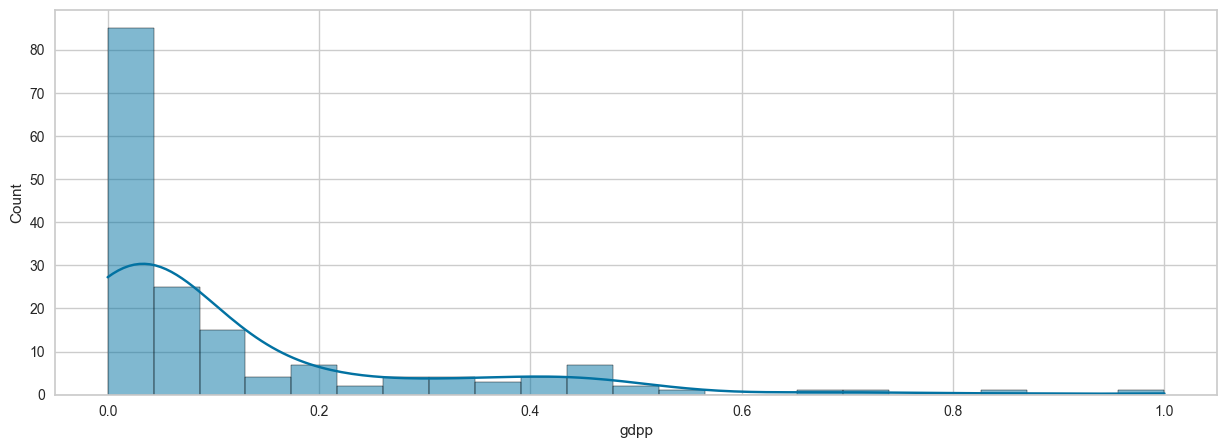

In [15]:
normalized_df2 = normalized_df.copy()
box_plot(normalized_df2['gdpp'])
histogram(normalized_df2['gdpp'])

In [16]:
normalized_df2, linhas_removidas = remove_outliers(normalized_df2, 'gdpp')
print(f'{linhas_removidas} linhas removidas')

25 linhas removidas


(142, 7)


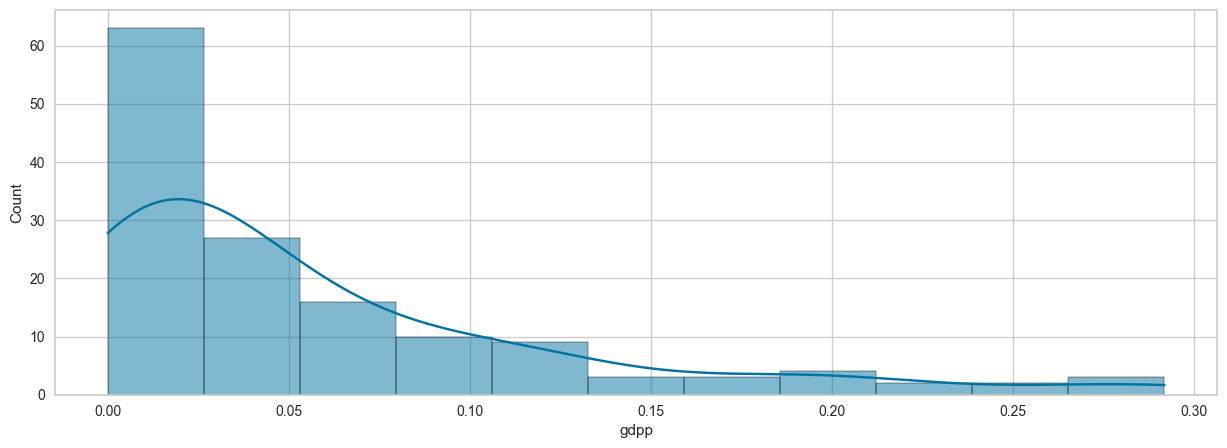

In [17]:
histogram(normalized_df2['gdpp'])
print(normalized_df2.shape)

### Vamos ver se é possível agrupar com Teste de Hopkins
- Resultado próximo de 1 → existe estrutura de cluster (distribuição não aleatória).
- Resultado próximo de 0.5 → dados aleatórios → sem clusters naturais.
- Resultado muito baixo (< 0.3) → pode indicar dispersão homogênea sem tendência a agrupamento.

### Fórmula do Hopkins Statistic

O Hopkins Statistic é definido como:

$$
H = \frac{\sum_{i=1}^{m} u_i}{\sum_{i=1}^{m} u_i + \sum_{i=1}^{m} w_i}
$$

Onde:

- \( u_i \): distância do ponto sintético (aleatório/uniforme) ao vizinho real mais próximo  
- \( w_i \): distância do ponto real (amostrado) ao vizinho real mais próximo (exceto ele mesmo)  
- \( m \): número de pontos amostrados

---

### Exemplo de cálculo

Considere 5 pontos sintéticos e 5 pontos reais com as seguintes distâncias ao vizinho mais próximo:

- Pontos sintéticos (uniformes):  
  u = [0.9, 0.8, 1.1, 0.95, 1.0] = 4.75
- Pontos reais (amostrados):  
   w = [0.2, 0.3, 0.1, 0.25, 0.15] = 1.0

Cálculo:

$$
\sum u = 4.75 \quad \text{e} \quad \sum w = 1.0
$$

$$
H = \frac{4.75}{4.75 + 1.0} = \frac{4.75}{5.75} \approx 0.826
$$

**Interpretação:**  
Um valor de Hopkins igual a 0.826 indica que os dados têm forte tendência a formação de clusters.

#### Com Outlier

Hopkins Score: 1.0
Média da Dissimilaridade: 0.5857


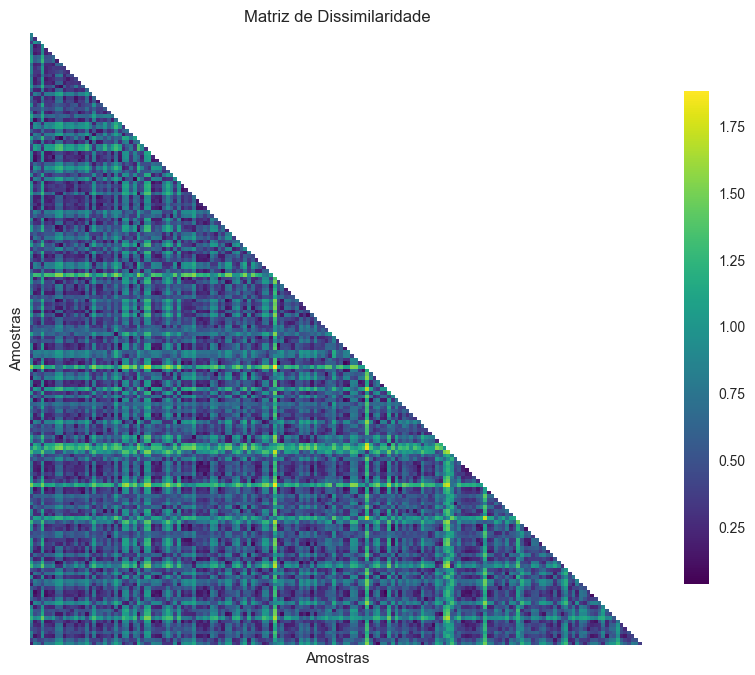

In [18]:
def hopkins_test(X, sample_size=0.1):
    n = len(X)
    m = int(sample_size * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    random_indices = np.random.choice(X.index, m, replace=False)
    random_points = X.iloc[random_indices]
    uniform_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, X.shape[1]))
    u_distances, _ = nbrs.kneighbors(uniform_points, n_neighbors=1)
    w_distances, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    hopkins_statistic = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
    return hopkins_statistic

hopkins_score = hopkins_test(normalized_df)
print(f"Hopkins Score: {hopkins_score}")

dissimilarity_matrix = pdist(normalized_df, metric='euclidean')
mean_dissimilarity = np.mean(dissimilarity_matrix)
print(f"Média da Dissimilaridade: {mean_dissimilarity:.4f}")

dissimilarity_matrix_square = squareform(dissimilarity_matrix)
mask = np.triu(np.ones_like(dissimilarity_matrix_square, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(dissimilarity_matrix_square, mask=mask, cmap="viridis", square=True, cbar_kws={"shrink": 0.8}, xticklabels=False, yticklabels=False)
plt.title("Matriz de Dissimilaridade")
plt.xlabel("Amostras")
plt.ylabel("Amostras")
plt.show()

#### Sem Outlier

Hopkins Score: 1.0
Média da Dissimilaridade: 0.5163


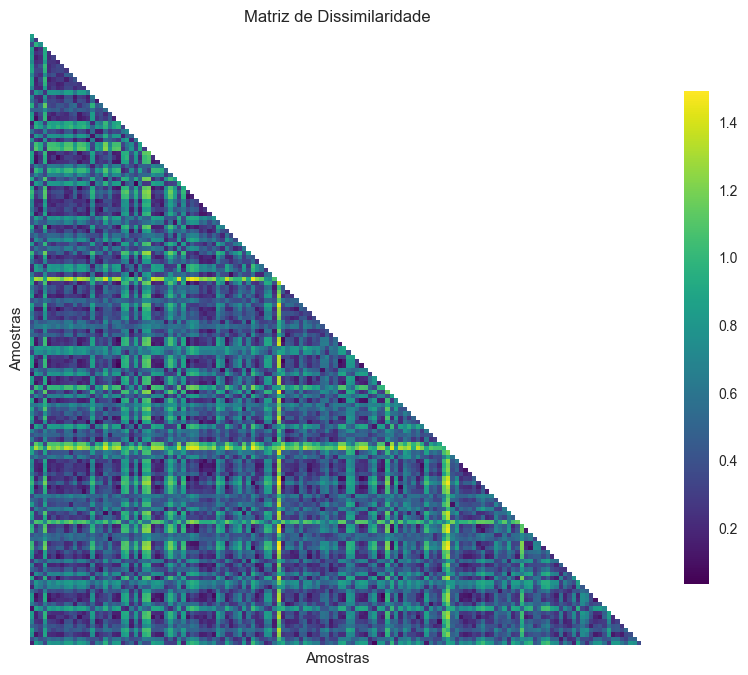

In [19]:
def hopkins_test_df_sem_outlier(X, sample_size=0.1):
    n = len(X)
    m = int(sample_size * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    random_points = X.sample(n=m, replace=False)
    uniform_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, X.shape[1]))
    u_distances, _ = nbrs.kneighbors(uniform_points, n_neighbors=1)
    w_distances, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    hopkins_statistic = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
    return hopkins_statistic

hopkins_score = hopkins_test_df_sem_outlier(normalized_df2)
print(f"Hopkins Score: {hopkins_score}")

dissimilarity_matrix = pdist(normalized_df2, metric='euclidean')
mean_dissimilarity = np.mean(dissimilarity_matrix)
print(f"Média da Dissimilaridade: {mean_dissimilarity:.4f}")

dissimilarity_matrix_square = squareform(dissimilarity_matrix)
mask = np.triu(np.ones_like(dissimilarity_matrix_square, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(dissimilarity_matrix_square, mask=mask, cmap="viridis", square=True, cbar_kws={"shrink": 0.8}, xticklabels=False, yticklabels=False)
plt.title("Matriz de Dissimilaridade")
plt.xlabel("Amostras")
plt.ylabel("Amostras")
plt.show()

### Método Elbow
"Como k-medoids minimiza uma soma de dissimilaridades aos pares em vez de uma soma de distâncias euclidianas ao quadrado, é mais robusto a ruído e outliers do que k-means."
<br><br>
https://pt.wikipedia.org/wiki/K-medoides



#### Distância ao quadrado (K-Means):
- Amplifica o impacto de outliers.
- Um ponto distante influencia muito o centróide.

#### Dissimilaridade simples (K-Medoids):
- Cada ponto tem peso proporcional.
- Outliers não distorcem tanto o medoide porque ele é um ponto real que minimiza o custo total de dissimilaridade, e não uma média distorcida.

<img src="img/kmeansXkmedoids.png" height="400"/>

<br><br><br>

<p>Fonte da imagem: <a href="https://www.researchgate.net/figure/The-graphical-representation-of-the-difference-between-the-k-means-and-k-medoids_fig1_342871651" target="_blank">
https://www.researchgate.net/figure/The-graphical-representation-of-the-difference-between-the-k-means-and-k-medoids_fig1_342871651</a></p>

#### Com Outliers

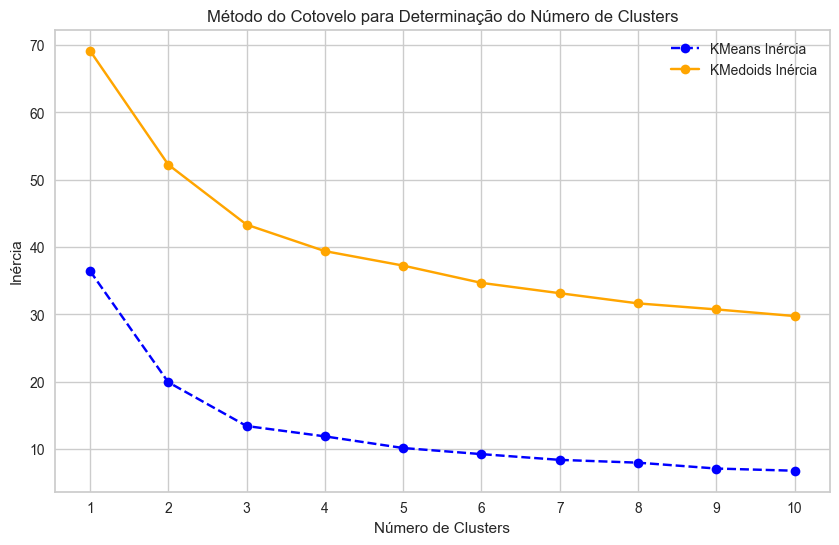

In [20]:
k_values = range(1, 11)

inertias_kmeans = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_df)
    inertias_kmeans.append(kmeans.inertia_)

inertias_kmedoids = []
for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam')
    kmedoids.fit(normalized_df)
    inertias_kmedoids.append(kmedoids.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias_kmeans, marker='o', linestyle='--', color='blue', label='KMeans Inércia')
plt.plot(k_values, inertias_kmedoids, marker='o', color='orange', label='KMedoids Inércia')
plt.title("Método do Cotovelo para Determinação do Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.xticks(k_values)
plt.legend()
plt.show()

#### Sem Outliers

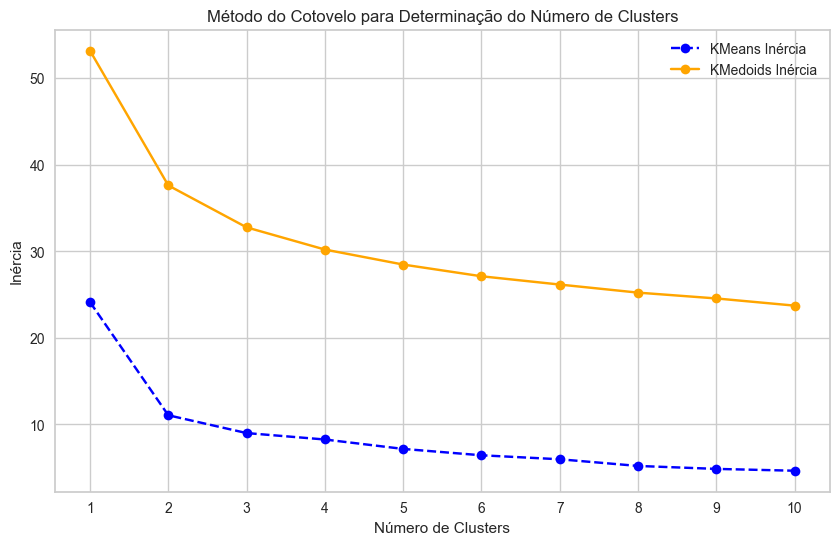

In [21]:
inertias_kmeans = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_df2)
    inertias_kmeans.append(kmeans.inertia_)

inertias_kmedoids = []
for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam')
    kmedoids.fit(normalized_df2)
    inertias_kmedoids.append(kmedoids.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias_kmeans, marker='o', linestyle='--', color='blue', label='KMeans Inércia')
plt.plot(k_values, inertias_kmedoids, marker='o', color='orange', label='KMedoids Inércia')
plt.title("Método do Cotovelo para Determinação do Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.xticks(k_values)
plt.legend()
plt.show()

### Utilizando KElbowVisualizer para ter uma segunda visão
Com outra medida de distância para ser justo.

<p>
Distortion é uma métrica que usa distâncias reais, sem elevar ao quadrado, o que torna a comparação entre algoritmos mais justa.</p>

<p>
Quanto menor o score, mais próximo da média os pontos estão.</p>

#### Com Outliers

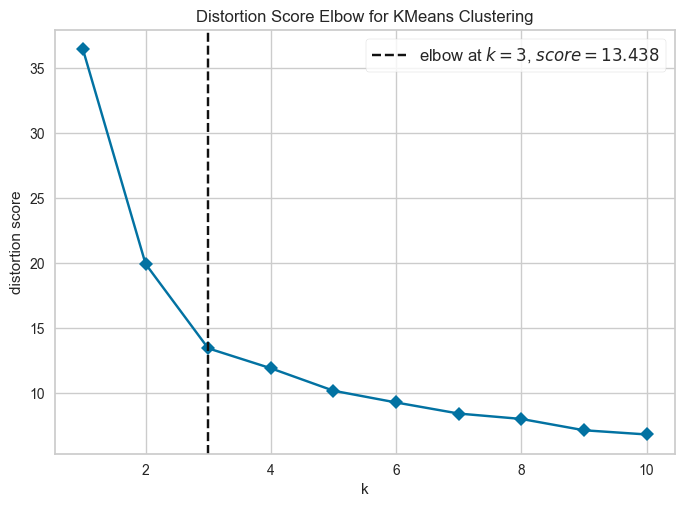

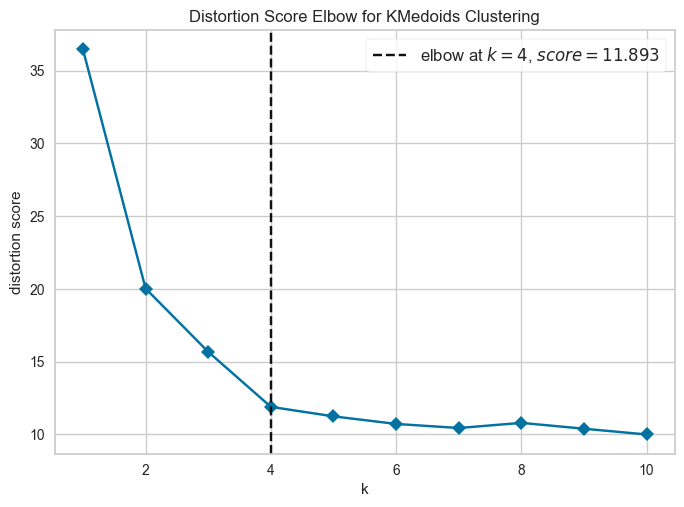

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
model_kmeans = KMeans(random_state=42)
visualizer_kmeans = KElbowVisualizer(model_kmeans, k=(1, 11), metric='distortion', timings=False)
visualizer_kmeans.fit(normalized_df)
visualizer_kmeans.show()

model_kmedoids = KMedoids(random_state=42)
visualizer_kmedoids = KElbowVisualizer(model_kmedoids, k=(1, 11), metric='distortion', timings=False)
visualizer_kmedoids.fit(normalized_df)
visualizer_kmedoids.show()

#### Sem Outliers

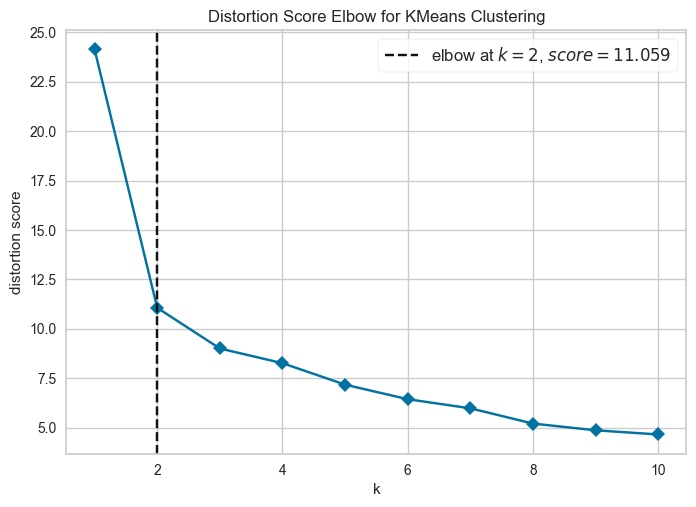

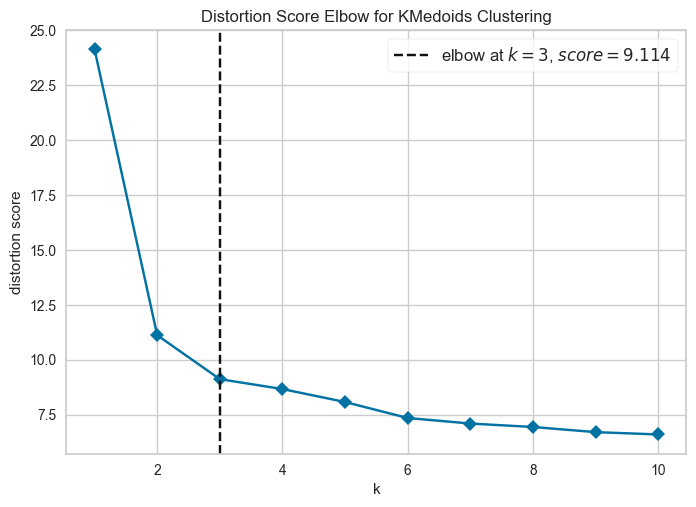

<Axes: title={'center': 'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
model_kmeans = KMeans(random_state=42)
visualizer_kmeans = KElbowVisualizer(model_kmeans, k=(1, 11), metric='distortion', timings=False)
visualizer_kmeans.fit(normalized_df2)
visualizer_kmeans.show()

model_kmedoids = KMedoids(random_state=42)
visualizer_kmedoids = KElbowVisualizer(model_kmedoids, k=(1, 11), metric='distortion', timings=False)
visualizer_kmedoids.fit(normalized_df2)
visualizer_kmedoids.show()

### Silhouette Score

#### Avalia a homogeneidade dos valores intra-clusters, o quão semelhantes são os valores de cada cluster porque eles precisam ser o mais parecidos possíveis para que faça sentido agrupá-los. Ao mesmo tempo avalia a distância inter-cluster, tendo que ser a maior possível. Em síntese, identifica a menor distância dentro do cluster e maximiza a distância entre os diferentes clusters.

- Valores entre 0,5 e 1 estão bem agrupados
- Valores entre 0 e 0,5 estão com uma qualidade média, mas pode haver sobreposição entre clusters ou podem não estar bem definidos
- Valores negativos significa que estão no cluster errado


$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Onde:

-  s(i) : Silhouette Score para o ponto (i)
-  a(i): Distância média do ponto (i) para todos os outros pontos no mesmo cluster.
-  b(i): Distância média do ponto (i) para todos os pontos no cluster mais próximo (o cluster vizinho).
- max(a(i), b(i)) : O maior valor entre  a(i)  e b(i), usado para normalizar o Silhouette Score no intervalo de -1 a 1.

#### Com Outlier

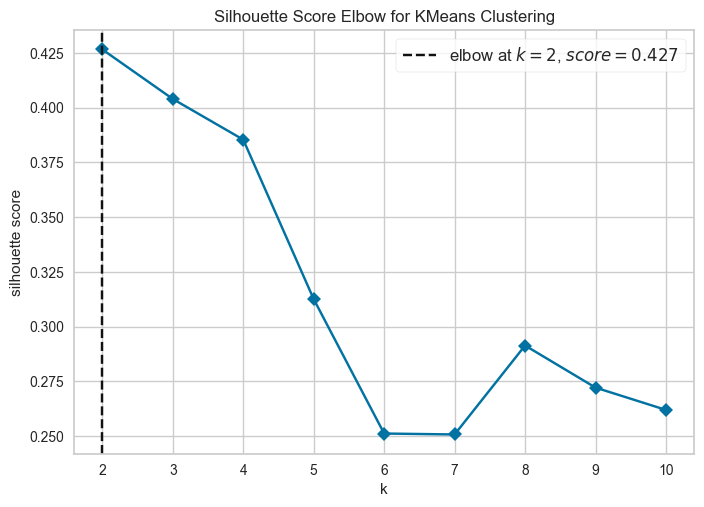

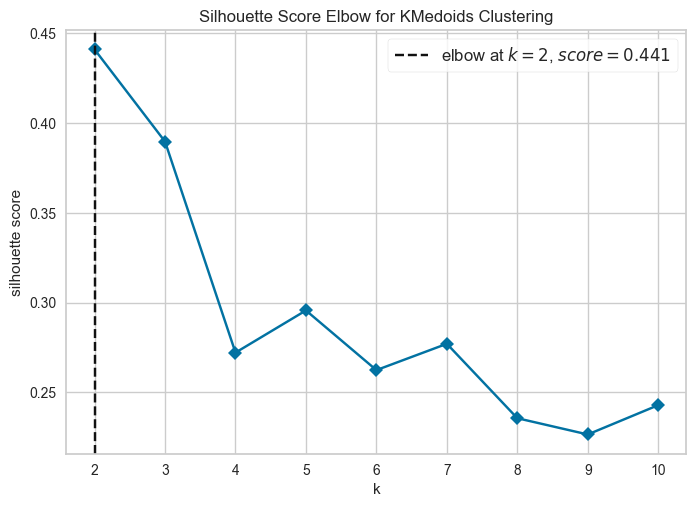

<Axes: title={'center': 'Silhouette Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='silhouette score'>

In [24]:
# KMeans com Silhouette
model_kmeans = KMeans(random_state=42)
visualizer_kmeans = KElbowVisualizer(model_kmeans, k=(2, 11), metric='silhouette', timings=False)
visualizer_kmeans.fit(normalized_df)
visualizer_kmeans.show()

# KMedoids com Silhouette
model_kmedoids = KMedoids(random_state=42, method='pam')
visualizer_kmedoids = KElbowVisualizer(model_kmedoids, k=(2, 11), metric='silhouette', timings=False)
visualizer_kmedoids.fit(normalized_df)
visualizer_kmedoids.show()

#### Sem Outlier

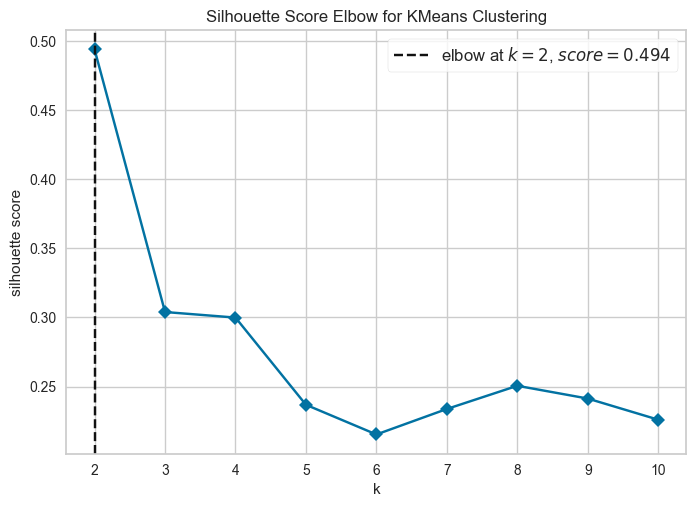

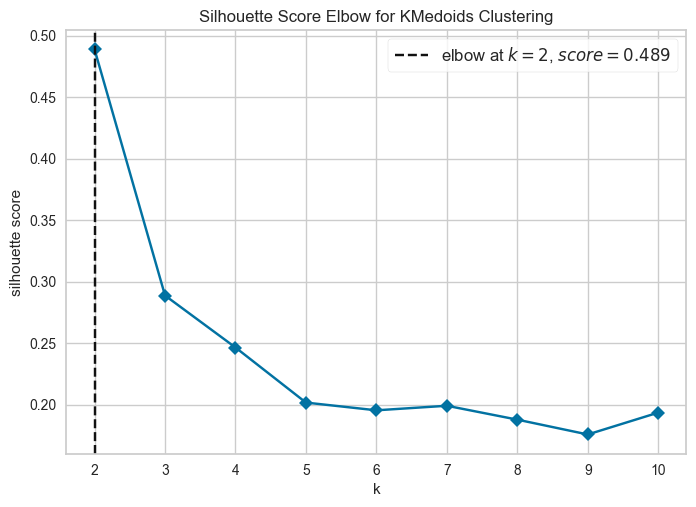

<Axes: title={'center': 'Silhouette Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='silhouette score'>

In [25]:
# KMeans com Silhouette
model_kmeans = KMeans(random_state=42)
visualizer_kmeans = KElbowVisualizer(model_kmeans, k=(2, 11), metric='silhouette', timings=False)
visualizer_kmeans.fit(normalized_df2)
visualizer_kmeans.show()

# KMedoids com Silhouette
model_kmedoids = KMedoids(random_state=42, method='pam')
visualizer_kmedoids = KElbowVisualizer(model_kmedoids, k=(2, 11), metric='silhouette', timings=False)
visualizer_kmedoids.fit(normalized_df2)
visualizer_kmedoids.show()

### Scatterplot dos Clusters

#### Normalized 1

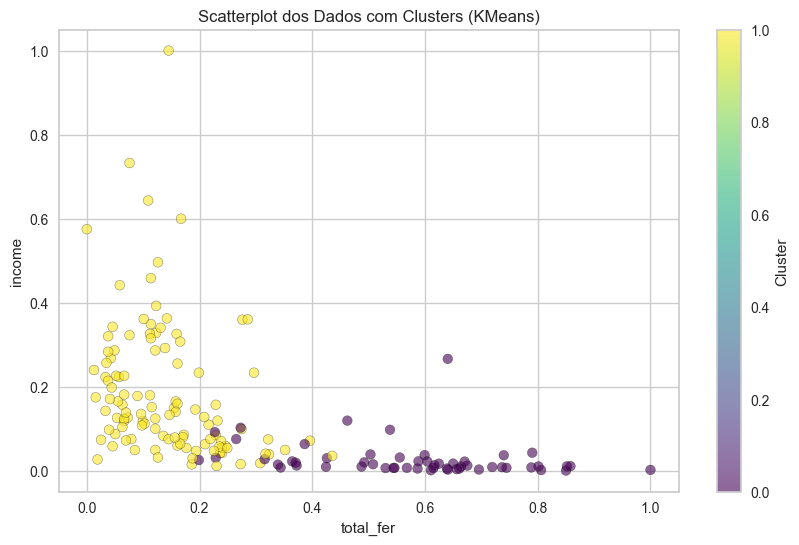

In [26]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(normalized_df)
labels = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(normalized_df['total_fer'], normalized_df['income'], c=labels, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title('Scatterplot dos Dados com Clusters (KMeans)')
plt.xlabel('total_fer')
plt.ylabel('income')
plt.colorbar(label='Cluster')
plt.show()

In [27]:
df_com_cluster = df.copy()
df_com_cluster['cluster'] = labels

In [28]:
df_com_cluster.cluster.value_counts()

cluster
1    112
0     55
Name: count, dtype: int64

In [29]:
df_com_cluster[df_com_cluster['cluster']==0].head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,0
21,Botswana,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350,0
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,0
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,0
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,0
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,0
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,0


In [39]:
# df_com_cluster[df_com_cluster['cluster']==1].head(10)

In [30]:
df_com_cluster.groupby('cluster')['gdpp'].mean().reset_index()

,cluster,gdpp
0,0,1971.600000
1,1,18362.285714


In [31]:
df_com_cluster[df_com_cluster['country']=='Brazil']

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
22,Brazil,19.8,10.7,9.01,11.8,14500,8.41,74.2,1.8,11200,1


#### Normalized 2

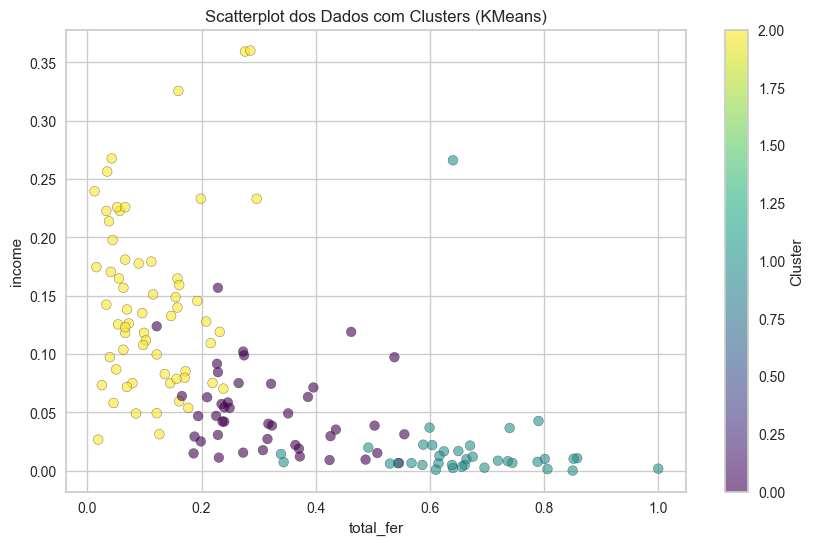

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(normalized_df2)
labels = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(normalized_df2['total_fer'], normalized_df2['income'], c=labels, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title('Scatterplot dos Dados com Clusters (KMeans)')
plt.xlabel('total_fer')
plt.ylabel('income')
plt.colorbar(label='Cluster')
plt.show()

In [33]:
# na verdade menos outliers
df_com_cluster_sem_outlier = df.loc[normalized_df2.index].reset_index(drop=True)
df_com_cluster_sem_outlier['cluster'] = labels

In [34]:
df_com_cluster_sem_outlier.cluster.value_counts()

cluster
2    62
0    44
1    36
Name: count, dtype: int64

In [35]:
df_com_cluster_sem_outlier[df_com_cluster_sem_outlier['cluster']==0].head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0
7,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,0
10,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,0
13,Belize,18.8,58.2,5.20,57.5,7880,1.140,71.4,2.71,4340,0
15,Bhutan,42.7,42.5,5.20,70.7,6420,5.990,72.1,2.38,2180,0
16,Bolivia,46.6,41.2,4.84,34.3,5410,8.780,71.6,3.20,1980,0
18,Botswana,52.5,43.6,8.30,51.3,13300,8.920,57.1,2.88,6350,0
23,Cambodia,44.4,54.1,5.68,59.5,2520,3.120,66.1,2.88,786,0
25,Cape Verde,26.5,32.7,4.09,61.8,5830,0.505,72.5,2.67,3310,0
39,Dominican Republic,34.4,22.7,6.22,33.3,11100,5.440,74.6,2.60,5450,0


In [36]:
df_com_cluster_sem_outlier.groupby('cluster')['gdpp'].mean().reset_index()

,cluster,gdpp
0,0,3039.113636
1,1,1440.361111
2,2,11529.677419


In [37]:
df_com_cluster_sem_outlier[df_com_cluster_sem_outlier['country']=='Brazil']

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
19,Brazil,19.8,10.7,9.01,11.8,14500,8.41,74.2,1.8,11200,2
